<a href="https://colab.research.google.com/github/Lee-Gunju/GraphEmbedding-For-Soccer-Tactical-Formations/blob/main/football_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# wide & deep learning model 
# 3개의 아웃풋 (포메이션, 스타일, 승리 가능성) 


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


In [ ]:
dataframe = pd.read_excel('Data.xlsx',  sheet_name = ['19-20', '18-19', '17-18', '16-17', '15-16', '14-15', '13-14', '12-13', '11-12', '10-11'])
concat_df = pd.concat(dataframe, axis= 0, ignore_index=True)

In [ ]:
concat_df.head(1)

,match_oder,oppense_team,FW0,FW0B,FW1,AMF0,AMF0B,AMF1,AMF1B,Wing0,Wing0B,Wing1,Wing1B,CMF0,CMF0B,CMF0C,CMF1,CMF1B,DMF0,DMF1,DMF1B,WB0,WB0B,WB1,WB1B,CB0,CB0B,CB1,CB1B,GK0,GK1,Formation,Opp_Level,Season,Ball_pos,Win,Style,sum
0,1 round,Aston Villa,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,0,1,1,0,0,1,0,4-1-2-1-2,Low,2019-2020,70.1,Win,0,11


데이터 변수 - 
match_order = 범위값
oppense_team = 범위값 
Position = 숫자(0, 1)
Opp_Level = 범위 
Season = 범위 
Ball_pos = 숫자 (연속?)

라벨 -
Formation = 라벨(범위) 
Win = 범위 (승무패)
Style = 범위 (0, 1)

In [ ]:
label_formation = concat_df['Formation'].unique().tolist()
season = concat_df['Season'].unique().tolist()
opp_level = concat_df['Opp_Level'].unique().tolist()
oppense_team = concat_df['oppense_team'].unique().tolist()
match_order = concat_df['match_oder'].unique().tolist()
win_cate = concat_df['Win'].unique().tolist()


In [ ]:
formation_to_encoded = {x: i for i, x in enumerate(label_formation)}
index_to_formation = {i: x for i, x in enumerate(label_formation)}

season_to_encoded = {x: i for i, x in enumerate(season)}
index_to_season = {i: x for i, x in enumerate(season)} 

opp_level_to_encoded = {x: i for i, x in enumerate(opp_level)}
index_to_opp_level = {i: x for i, x in enumerate(opp_level)} 

oppense_team_to_encoded = {x: i for i, x in enumerate(oppense_team)}
index_to_oppense_team = {i: x for i, x in enumerate(oppense_team)} 

match_order_to_encoded = {x: i for i, x in enumerate(match_order)}
index_to_match_order = {i: x for i, x in enumerate(match_order)} 

win_to_encoded = {x: i for i, x in enumerate(win_cate)}
index_to_win = {i: x for i, x in enumerate(win_cate)} 

In [ ]:
concat_df['label'] = concat_df['Formation'].map(formation_to_encoded)
concat_df['Match_order'] = concat_df['match_oder'].map(match_order_to_encoded)
concat_df['Oppense_team'] = concat_df['oppense_team'].map(oppense_team_to_encoded)
concat_df['Oppense_level'] = concat_df['Opp_Level'].map(opp_level_to_encoded)
concat_df['season'] = concat_df['Season'].map(season_to_encoded)

concat_df['win_index'] = concat_df['Win'].map(win_to_encoded)

In [ ]:
min_match_order = min(concat_df["Match_order"])
max_match_order = max(concat_df["Match_order"])

min_oppense_team = min(concat_df["Oppense_team"])
max_oppense_team = max(concat_df["Oppense_team"])


min_oppense_level = min(concat_df["Oppense_level"])
max_oppense_level = max(concat_df["Oppense_level"])

min_season = min(concat_df["season"])
max_season = max(concat_df["season"])

min_ball_pos = min(concat_df['Ball_pos'])
max_ball_pos = max(concat_df['Ball_pos'])

In [ ]:
concat_df['reg_match_order'] = concat_df["Match_order"].apply(lambda x: (x - min_match_order) / (max_match_order - min_match_order)).values
concat_df['reg_oppense_team'] = concat_df["Oppense_team"].apply(lambda x: (x - min_oppense_team) / (max_oppense_team - min_oppense_team)).values
concat_df['reg_oppense_level'] = concat_df["Oppense_level"].apply(lambda x: (x - min_oppense_level) / (max_oppense_level - min_oppense_level)).values
concat_df['reg_season'] = concat_df["season"].apply(lambda x: (x - min_season) / (max_season - min_season)).values
concat_df['reg_ball_pos'] = concat_df["Ball_pos"].apply(lambda x: (x - min_ball_pos) / (max_ball_pos - min_ball_pos)).values

In [ ]:
df = concat_df.sample(frac=1, random_state=42)

In [ ]:
df.head(1)

,match_oder,oppense_team,FW0,FW0B,FW1,AMF0,AMF0B,AMF1,AMF1B,Wing0,Wing0B,Wing1,Wing1B,CMF0,CMF0B,CMF0C,CMF1,CMF1B,DMF0,DMF1,DMF1B,WB0,WB0B,WB1,WB1B,CB0,CB0B,CB1,CB1B,GK0,GK1,Formation,Opp_Level,Season,Ball_pos,Win,Style,sum,label,Match_order,Oppense_team,Oppense_level,season,win_index,reg_match_order,reg_oppense_team,reg_oppense_level,reg_season,reg_ball_pos
266,1 round,New castle,1,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,4-0-2-1-3,Low,2012-2013,48.1,Lose,1,11,5,0,2,0,7,2,0.0,0.058824,0.0,0.777778,0.40884


In [ ]:
# feature의 값을 정규화 적용
x = df[["FW0", "FW0B", "FW1" ,'AMF0', 'AMF0B', 'AMF1', 'AMF1B',
       'Wing0', 'Wing0B', 'Wing1', 'Wing1B', 'CMF0', 'CMF0B', 'CMF0C', 'CMF1',
       'CMF1B', 'DMF0', 'DMF1', 'DMF1B', 'WB0', 'WB0B', 'WB1', 'WB1B', 'CB0',
       'CB0B', 'CB1', 'CB1B', 'GK0', 'GK1', 'reg_oppense_team', 'reg_oppense_level','reg_season','reg_ball_pos']].values.astype(np.float)



y_formation = df["label"].values.astype(np.float)
y_win_rating = df['win_index'].values.astype(np.float)
y_style = df['Style'].values.astype(np.float)

In [ ]:
train_indices = int(0.9 * df.shape[0])

In [ ]:
x_train, x_val, y_train_formation, y_val_formation, y_train_win_rating, y_val_win_rating, y_train_style, y_val_style = (
    x[:train_indices],
    x[train_indices:],
    y_formation[:train_indices],
    y_formation[train_indices:],
    y_win_rating[:train_indices],
    y_win_rating[train_indices:],
    y_style[:train_indices],
    y_style[train_indices:],

)

In [ ]:
# 데이터를 나눈다.
x_train_A, x_train_B = x_train[:, :32], x_train[:, 32:]
x_val_A, x_val_B = x_val[:, :32], x_val[:, 32:]

In [ ]:
print(x_train_A.shape, x_train_B.shape)

(342, 32) (342, 1)


In [ ]:
learning_rate = 0.01
dropout_rate = 0.1

In [ ]:
def wide_deep_model():
  input_A = layers.Input(shape = (x_train_A.shape[1]), name = 'wide_input')
  input_B = layers.Input(shape = (x_train_B.shape[1]), name = 'deep_input')

  x = layers.Dense(64, activation='relu')(input_B)
  x = layers.Dense(64, activation='relu')(x)

  concat = layers.concatenate([input_A, x], name = 'concat')

  x_1 = layers.Dense(42, kernel_regularizer=keras.regularizers.l2(0.001))(concat)
  x_1 = layers.BatchNormalization()(x_1)
  x_1 = layers.ReLU()(x_1)
  x_1 = layers.Dropout(dropout_rate)(x_1)
  output_for = layers.Dense(31, activation='softmax', name='output_for')(x_1)

  x_2 = layers.Dense(42, kernel_regularizer=keras.regularizers.l2(0.001))(concat)
  x_2 = layers.BatchNormalization()(x_2)
  x_2 = layers.ReLU()(x_2)
  x_2 = layers.Dropout(dropout_rate)(x_2)
  output_style = layers.Dense(2, activation='softmax', name='output_style')(x_2)

  x_3 = layers.Dense(42, kernel_regularizer=keras.regularizers.l2(0.001))(concat)
  x_3 = layers.BatchNormalization()(x_3)
  x_3 = layers.ReLU()(x_3)
  x_3 = layers.Dropout(dropout_rate)(x_3)
  x_3 = layers.Dense(24, kernel_regularizer=keras.regularizers.l2(0.001))(x_3)
  x_3 = layers.BatchNormalization()(x_3)
  x_3 = layers.ReLU()(x_3)
  x_3 = layers.Dropout(dropout_rate)(x_3)
  x_3 = layers.Dense(12)(x_3)
  x_3 = layers.BatchNormalization()(x_3)
  x_3 = layers.ReLU()(x_3)
  x_3 = layers.Dropout(dropout_rate)(x_3)
  output_win = layers.Dense(3, activation='softmax', name='output_win')(x_3)



  model = keras.Model(inputs = [input_A, input_B], outputs = [output_for, output_style, output_win],  name = 'multi_model')

  return model 

In [ ]:
model = wide_deep_model()

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
              loss= {'output_for': keras.losses.SparseCategoricalCrossentropy(), 
                      'output_win':keras.losses.SparseCategoricalCrossentropy(), 
                      'output_style':keras.losses.SparseCategoricalCrossentropy()},
              metrics =[keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10, restore_best_weights=True)

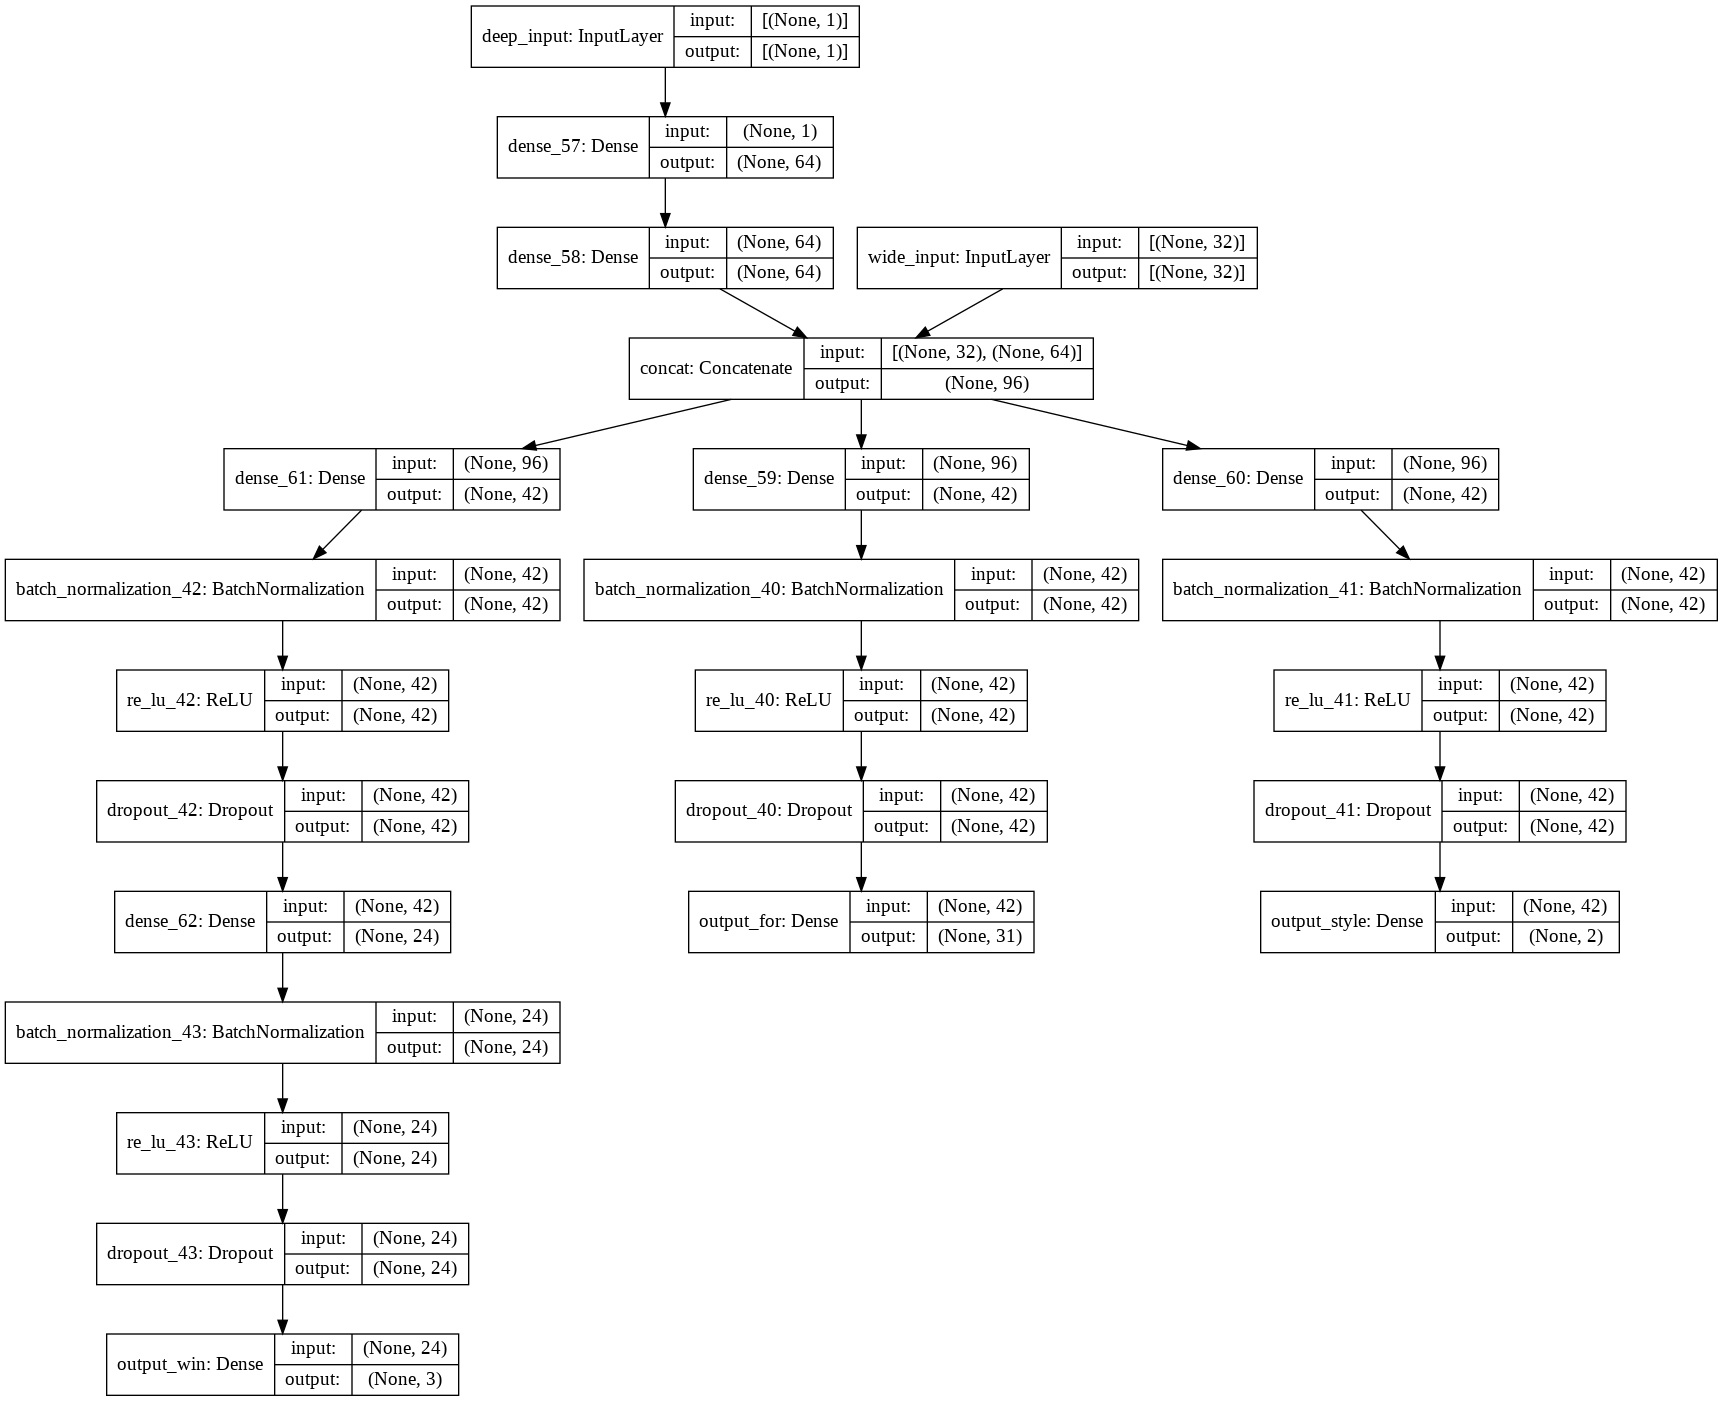

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(x=[x_train_A, x_train_B], y = [y_train_formation, y_train_style,y_train_win_rating], epochs=100, validation_split=0.2 , callbacks=[early_stop])

Epoch 1/100
9/9 [==============================] - 2s 53ms/step - loss: 4.9416 - output_for_loss: 2.9098 - output_style_loss: 0.6517 - output_win_loss: 1.2072 - output_for_sparse_categorical_accuracy: 0.2527 - output_style_sparse_categorical_accuracy: 0.6227 - output_win_sparse_categorical_accuracy: 0.3883 - val_loss: 4.3840 - val_output_for_loss: 2.5139 - val_output_style_loss: 0.6882 - val_output_win_loss: 1.0357 - val_output_for_sparse_categorical_accuracy: 0.4058 - val_output_style_sparse_categorical_accuracy: 0.5797 - val_output_win_sparse_categorical_accuracy: 0.4493
Epoch 2/100
9/9 [==============================] - 0s 12ms/step - loss: 2.7759 - output_for_loss: 1.4297 - output_style_loss: 0.2594 - output_win_loss: 0.9456 - output_for_sparse_categorical_accuracy: 0.6996 - output_style_sparse_categorical_accuracy: 0.8791 - output_win_sparse_categorical_accuracy: 0.5275 - val_loss: 4.5587 - val_output_for_loss: 2.0146 - val_output_style_loss: 1.3757 - val_output_win_loss: 1.0303 -

In [ ]:
model.evaluate(x=[x_val_A, x_val_B], y = [y_val_formation, y_val_style, y_val_win_rating])

# L2 정규화를 dense layer에 추가하니 살짝, 안정적으로 학습 진행됨! 

2/2 [==============================] - 0s 9ms/step - loss: 2.6305 - output_for_loss: 1.1181 - output_style_loss: 0.3379 - output_win_loss: 1.0543 - output_for_sparse_categorical_accuracy: 0.8684 - output_style_sparse_categorical_accuracy: 0.8684 - output_win_sparse_categorical_accuracy: 0.5000


[2.6305267810821533,
 1.1180543899536133,
 0.33794617652893066,
 1.0542573928833008,
 0.8684210777282715,
 0.8684210777282715,
 0.5]

In [ ]:
history.history.keys()

dict_keys(['loss', 'output_for_loss', 'output_style_loss', 'output_win_loss', 'output_for_sparse_categorical_accuracy', 'output_style_sparse_categorical_accuracy', 'output_win_sparse_categorical_accuracy', 'val_loss', 'val_output_for_loss', 'val_output_style_loss', 'val_output_win_loss', 'val_output_for_sparse_categorical_accuracy', 'val_output_style_sparse_categorical_accuracy', 'val_output_win_sparse_categorical_accuracy'])

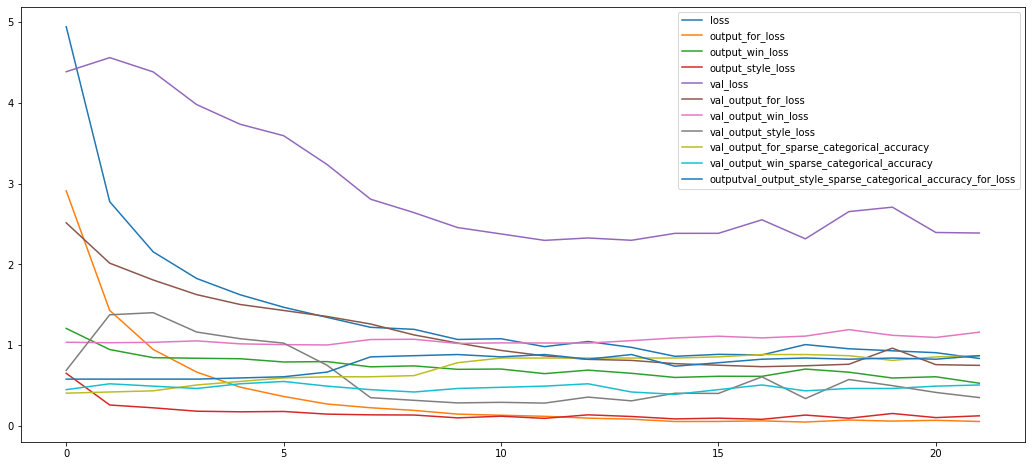

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,8))

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['output_for_loss'], label = 'output_for_loss')
plt.plot(history.history['output_win_loss'] ,label = 'output_win_loss')
plt.plot(history.history['output_style_loss'],label = 'output_style_loss')

# plt.plot(history.history['output_for_sparse_categorical_accuracy'],label = 'output_for_sparse_categorical_accuracy')
# plt.plot(history.history['output_win_sparse_categorical_accuracy'],label = 'output_win_sparse_categorical_accuracy')
# plt.plot(history.history['output_style_sparse_categorical_accuracy'],label = 'output_style_sparse_categorical_accuracy')

plt.plot(history.history['val_loss'],label = 'val_loss')
plt.plot(history.history['val_output_for_loss'],label = 'val_output_for_loss')
plt.plot(history.history['val_output_win_loss'],label = 'val_output_win_loss')
plt.plot(history.history['val_output_style_loss'],label = 'val_output_style_loss')

plt.plot(history.history['val_output_for_sparse_categorical_accuracy'],label = 'val_output_for_sparse_categorical_accuracy')
plt.plot(history.history['val_output_win_sparse_categorical_accuracy'],label = 'val_output_win_sparse_categorical_accuracy')
plt.plot(history.history['val_output_style_sparse_categorical_accuracy'],label = 'outputval_output_style_sparse_categorical_accuracy_for_loss')

plt.legend(loc = 'upper right')
         

In [ ]:
def wide_deep_model_with_sigmoid():
  input_A = layers.Input(shape = (x_train_A.shape[1]), name = 'wide_input')
  input_B = layers.Input(shape = (x_train_B.shape[1]), name = 'deep_input')

  x = layers.Dense(64, activation='relu')(input_B)
  x = layers.Dense(64, activation='relu')(x)

  concat = layers.concatenate([input_A, x], name = 'concat')

  x_1 = layers.Dense(42)(concat)
  x_1 = layers.BatchNormalization()(x_1)
  x_1 = layers.ReLU()(x_1)
  x_1 = layers.Dropout(dropout_rate)(x_1)
  output_for = layers.Dense(31, activation='softmax', name='output_for')(x_1)

  x_2 = layers.Dense(42)(concat)
  x_2 = layers.BatchNormalization()(x_2)
  x_2 = layers.ReLU()(x_2)
  x_2 = layers.Dropout(dropout_rate)(x_2)
  output_style = layers.Dense(2, activation='softmax', name='output_style')(x_2)

  x_3 = layers.Dense(42)(concat)
  x_3 = layers.BatchNormalization()(x_3)
  x_3 = layers.ReLU()(x_3)
  x_3 = layers.Dropout(dropout_rate)(x_3)
  x_3 = layers.Dense(24)(x_3)
  x_3 = layers.BatchNormalization()(x_3)
  x_3 = layers.ReLU()(x_3)
  x_3 = layers.Dropout(dropout_rate)(x_3)
  x_3 = layers.Dense(12)(x_3)
  x_3 = layers.BatchNormalization()(x_3)
  x_3 = layers.ReLU()(x_3)
  x_3 = layers.Dropout(dropout_rate)(x_3)
  output_win = layers.Dense(3, activation='sigmoid', name='output_win')(x_3)



  model = keras.Model(inputs = [input_A, input_B], outputs = [output_for, output_style, output_win],  name = 'multi_model')

  return model 

In [ ]:
model = wide_deep_model_with_sigmoid()
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), 
              
              loss= {'output_for': keras.losses.SparseCategoricalCrossentropy(),  
                      'output_style':keras.losses.SparseCategoricalCrossentropy(),
                     'output_win':keras.losses.CategoricalCrossentropy()},
              
              metrics ={'output_for': keras.metrics.SparseCategoricalAccuracy(),  
                      'output_style':keras.metrics.SparseCategoricalAccuracy(),
                      'output_win':keras.metrics.CategoricalAccuracy()}
              )

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10, restore_best_weights=True)

In [ ]:
history = model.fit(x=[x_train_A, x_train_B], y = [y_train_formation, y_train_style, tf.keras.utils.to_categorical(y_train_win_rating, 3)], epochs=100, batch_size = 24, validation_split=0.2 , callbacks=[early_stop])

Epoch 1/100
12/12 [==============================] - 2s 44ms/step - loss: 5.3877 - output_for_loss: 3.2507 - output_style_loss: 0.7945 - output_win_loss: 1.3425 - output_for_sparse_categorical_accuracy: 0.1941 - output_style_sparse_categorical_accuracy: 0.5201 - output_win_categorical_accuracy: 0.3480 - val_loss: 4.6442 - val_output_for_loss: 2.8504 - val_output_style_loss: 0.6961 - val_output_win_loss: 1.0978 - val_output_for_sparse_categorical_accuracy: 0.3768 - val_output_style_sparse_categorical_accuracy: 0.5362 - val_output_win_categorical_accuracy: 0.3623
Epoch 2/100
12/12 [==============================] - 0s 11ms/step - loss: 3.7867 - output_for_loss: 2.1482 - output_style_loss: 0.5992 - output_win_loss: 1.0393 - output_for_sparse_categorical_accuracy: 0.5018 - output_style_sparse_categorical_accuracy: 0.6996 - output_win_categorical_accuracy: 0.5018 - val_loss: 4.1185 - val_output_for_loss: 2.4172 - val_output_style_loss: 0.6701 - val_output_win_loss: 1.0313 - val_output_for_s

In [ ]:
model.evaluate(x=[x_val_A, x_val_B], y = [y_val_formation, y_val_style, tf.keras.utils.to_categorical(y_val_win_rating, 3)])

# win_output의 activation func을 sigmoid로 바꿔도 별 차이 없다..... 승패 예측은 별 차이없음!!! 
# optimizer를 SGD도 Adam과 큰 차이가 없다.
# 

2/2 [==============================] - 0s 9ms/step - loss: 2.4102 - output_for_loss: 1.0666 - output_style_loss: 0.3307 - output_win_loss: 1.0129 - output_for_sparse_categorical_accuracy: 0.8421 - output_style_sparse_categorical_accuracy: 0.8421 - output_win_categorical_accuracy: 0.5000


[2.410229444503784,
 1.0666239261627197,
 0.3306812644004822,
 1.012924313545227,
 0.8421052694320679,
 0.8421052694320679,
 0.5]

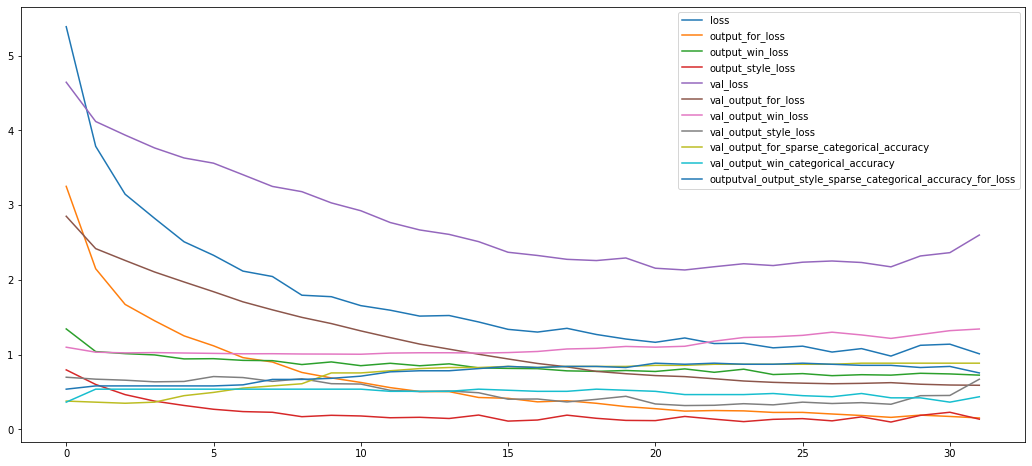

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,8))

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['output_for_loss'], label = 'output_for_loss')
plt.plot(history.history['output_win_loss'] ,label = 'output_win_loss')
plt.plot(history.history['output_style_loss'],label = 'output_style_loss')

# plt.plot(history.history['output_for_sparse_categorical_accuracy'],label = 'output_for_sparse_categorical_accuracy')
# plt.plot(history.history['output_win_sparse_categorical_accuracy'],label = 'output_win_sparse_categorical_accuracy')
# plt.plot(history.history['output_style_sparse_categorical_accuracy'],label = 'output_style_sparse_categorical_accuracy')

plt.plot(history.history['val_loss'],label = 'val_loss')
plt.plot(history.history['val_output_for_loss'],label = 'val_output_for_loss')
plt.plot(history.history['val_output_win_loss'],label = 'val_output_win_loss')
plt.plot(history.history['val_output_style_loss'],label = 'val_output_style_loss')

plt.plot(history.history['val_output_for_sparse_categorical_accuracy'],label = 'val_output_for_sparse_categorical_accuracy')
plt.plot(history.history['val_output_win_categorical_accuracy'],label = 'val_output_win_categorical_accuracy')
plt.plot(history.history['val_output_style_sparse_categorical_accuracy'],label = 'outputval_output_style_sparse_categorical_accuracy_for_loss')

plt.legend(loc = 'upper right')